In [1]:
!python -m pip install git+https://github.com/huggingface/transformers -q

# **Import Statements**

In [2]:
from transformers import Qwen2VLForConditionalGeneration, AutoTokenizer, AutoProcessor
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image
from glob import glob
import requests
import re
from datetime import datetime

Functions for perfect extraction and visualization of information

In [3]:
def rotate_image(src):
    r0 = cv2.imread(src)
    r1 = cv2.rotate(r0, cv2.ROTATE_90_CLOCKWISE)
    r2 = cv2.rotate(r0, cv2.ROTATE_180)
    r3 = cv2.rotate(r0, cv2.ROTATE_90_COUNTERCLOCKWISE)
    return r0,r1,r2,r3
    
def plot_images(r1,r2,r3,r4):
    # Plotting the images
    plt.figure(figsize=(20, 5))
    # First image (r1)
    plt.subplot(1, 4, 1)
    plt.imshow(r1)
    plt.title("Rotated Image 1")
    # Second image (r2)
    plt.subplot(1, 4, 2)
    plt.imshow(r2)
    plt.title("Rotated Image 2")
    # Third image (r3)
    plt.subplot(1, 4, 3)
    plt.imshow(r3)
    plt.title("Rotated Image 3")
    # Fourth image (r4)
    plt.subplot(1, 4, 4)
    plt.imshow(r4)
    plt.title("Rotated Image 4")
    # Display the images
    plt.show()

def is_valid_date(date_str):
    # List of known date formats
    date_formats = [
        "%d/%m/%Y", "%d-%m-%Y", "%Y/%m/%d", "%Y-%m-%d",
        "%m/%d/%Y", "%m-%d-%Y", "%d %b %Y", "%d %B %Y",
        "%d/%m/%y", "%d-%m-%y", "%Y%m%d"
    ]
    # Try parsing the date using each format
    for date_format in date_formats:
        try:
            # Try to parse the date string using the current format
            datetime.strptime(date_str, date_format)
            return True
        except ValueError:
            continue
    return False

def model_initialization():
    model = Qwen2VLForConditionalGeneration.from_pretrained( "Qwen/Qwen2-VL-2B-Instruct", torch_dtype="auto", device_map="auto", )
    processor = AutoProcessor.from_pretrained( "Qwen/Qwen2-VL-2B-Instruct" )
    return model,processor

# Final_Model

In [4]:
def final_model(image_path):
    model,processor = model_initialization() # To initialize the Qwen Model
    r1,r2,r3,r4 = rotate_image(image_path) # To Rotate the Image
    image1 = Image.fromarray(r1)
    image2 = Image.fromarray(r2)
    image3 = Image.fromarray(r3)
    image4 = Image.fromarray(r4)
    images = [image1, image2, image3, image4]
    messages = [{ "role": "user",
                  "content": [
                { "type": "image",},
                { "type": "text", "text": {"find the class and expiry date of the product.Output it in the following format: class: class of the product, expiry date: expiry date of the product. Note: Don't print any extra output.Also, the classes shoud be from any one of these only [Staples, Snacks&Beverages, Packaged Food, Personal&Babycare, HouseholdCare, Dairy&eggs, Home&Kitchen]"}
                }] }]
    outputs=[]
    for img in images:
        text_prompt = processor.apply_chat_template(messages, add_generation_prompt=True)
        inputs = processor( text = [text_prompt], images = [img], padding = True, return_tensors = "pt" )
        inputs = inputs.to("cuda")
        output_ids = model.generate(**inputs, max_new_tokens=1024)
        generated_ids = [output_ids[len(input_ids) :]
        for input_ids, output_ids in zip(inputs.input_ids, output_ids)]
        output_text = processor.batch_decode( generated_ids, skip_special_tokens=True, clean_up_tokenization_spaces=True )
        outputs.append(output_text[0])
    final_dict = {
        'class' : set(),
        'expiry_date' : set()
    } # To store the extracted data
    for input_str in outputs:
        classes = re.findall(r'class: ([^,]+)', input_str)
        expiry_dates = re.findall(r'expiry date: ([^,]+)', input_str)
        valid_expiry_dates = [date for date in expiry_dates if is_valid_date(date)] # To check if extracted Expiry Date is valid or not
        if len(classes)>0:
            final_dict['class'].add(classes[0])
        if len(valid_expiry_dates)>0:
            final_dict['expiry_date'].add(valid_expiry_dates[0])
    print(final_dict)
    plot_images(image1, image2, image3, image4)

# TESTING

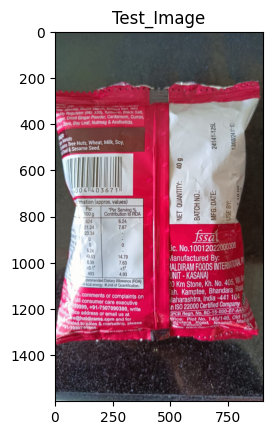

config.json:   0%|          | 0.00/1.20k [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/56.4k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/3.99G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/429M [00:00<?, ?B/s]

`Qwen2VLRotaryEmbedding` can now be fully parameterized by passing the model config through the `config` argument. All other arguments will be removed in v4.46


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/272 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/347 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/2.78M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.67M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/7.03M [00:00<?, ?B/s]

chat_template.json:   0%|          | 0.00/1.05k [00:00<?, ?B/s]

{'class': {'Packaged Food'}, 'expiry_date': {'13/08/24'}}


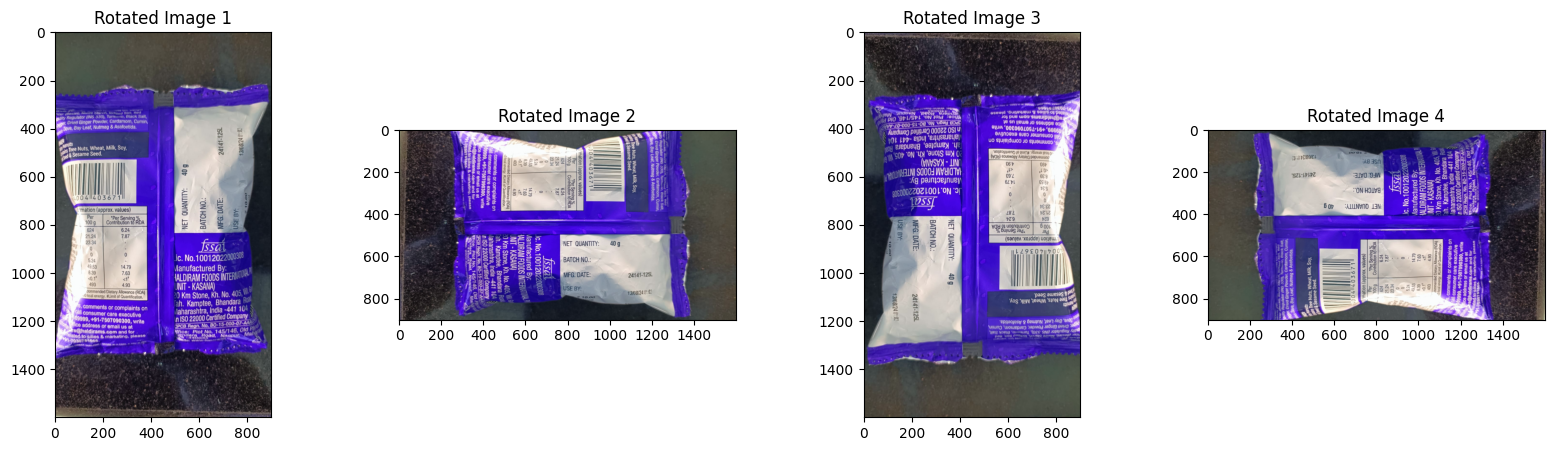

In [5]:
if __name__=="__main__":
    image_path = '/kaggle/input/abcdef/c2-2.jpg'
    plt.title('Test_Image')
    plt.imshow(plt.imread(image_path))
    plt.show()
    final_model(image_path)

**Note: The given Test_Image is rotated 4 times to extract the information which is printed vertically/horizontally on the product.**